# Parameters

There are three "flavors" of parameters in `prospect`: discovery parameters, time parameters, and indirect parameters. Each of the parameters are discussed in more detail along with the Python classes that define them, but they are summarized here.

## Discovery parameters

Discovery parameters help determine the probability that a `Feature` (i.e., an artifact) is recorded during a survey. There are four discovery parameters.

1. `vis`: surface visibility, defined at the `Area` object level
2. `ideal_obs_rate`: ideal observation rate of the material, defined at the `Feature` object level, but typically shared by all members of a `Layer`
3. `skill`: surveyor skill, defined at the `Surveyor` object level
4. `proximity`: location of a `Feature` relative to the `Coverage`; derived from spatial locations; currently can only be 1.0 (`Feature` intersects a `SurveyUnit`) or 0.0 (`Feature` does **not** intersect a `SurveyUnit`).

When a `Survey` is "run", `prospect` will determine a value for each of these parameters for each `Feature`. So for any individual `Feature`,

$P(discovery) = \text{visibility} \times \text{observation rate} \times \text{surveyor skill} \times \text{proximity}$

## Time parameters

Time parameters help determine the amount of time it will take to carry out a survey. There are three time parameters.

1. `time_penalty`: minimum time it takes to record one `Feature`, defined at the `Feature` object level, but typically shared by all members of a `Layer`
2. `speed_penalty`: surveyor speed penalty factor, defined at the `Surveyor` object level
3. `min_time_per_unit`: minimum base time required to survey a `SurveyUnit`; for `SurveyUnit` objects of variable size (i.e., transects), this is specified in terms of seconds per unit of distance

Search time for any given `SurveyUnit` is calculated in the following way:

$$\text{base penalty} = \text{base search time} + \sum \text{artifact time penalties}$$

$$\text{surveyor penalty} = \text{base penalty} \times \text{surveyor speed penalty factor}$$

$$\text{search time} = \text{base penalty} + \text{surveyor penalty}$$

## Indirect parameters

"Indirect" is the name I give to parameters that can influence the outcome of a survey but are not directly involved in calculations. Most of these are related to the spatial configuration of the survey. Some examples of indirect parameters would be: the spacing between survey units, the shape of the survey units, the point process used to distribute the features, etc.

## Modeling parameters

Almost all of the discovery and time parameters can be represented in two ways:

1. as fixed float values between 0.0 and 1.0
2. as `scipy.stats` distributions

The only discovery or time parameter that cannot be modeled with a distribution is `proximity`, which is derived from the spatial configuration. (It is my hope that in the future, this too could be modeled with a distance decay-type of model, but for now, a `Feature` is either in (1.0) or out (0.0) of the `SurveyUnit`.)

### Parameters as a fixed value

Parameters whose value is specified as a float will take that value in every run of the survey. In general, fixed-value parameters are not often realistic because there will always be variation in the field. Even when you are confident of the "real" value of a parameter (not often), it would be better to represent the parameter as a distribution with little spread.

The case where fixed-value parameters *are* quite useful is when you want to fully control for a **discovery** parameter. If the value is fixed, the none of the resulting *variation* in discovery probability will be due to that parameter. Further, if the value is fixed at 1.0, it effectively removes that parameter from having any influence on the final discovery probability.

Time parameters are not quite as straightforward. The `time_penalty` and `min_time_per_unit` do not function in this way because they are not modeling probabilities, but actual quantities of time. The `speed_penalty` parameter is a factor that can exceed 1.0, so it also cannot be thought of in the same ways as the discovery parameters.

### Parameters as distributions

Distributions are useful as parameters when you want to allow the value of a parameter to change between runs of a survey or even during the same run. For example, you may have a sense that surface visibility of an area is roughly 80% (or 0.8), but that the visibility at the location of any given artifact might vary somewhat from that value. By setting the visibility of the `Area` object to be a distribution, the visibility at any given artifact location will be a value randomly drawn from that distribution.

If you choose to model a parameter as a distribution, `prospect` will allow you to use any [`scipy.stats` continuous distribution](https://docs.scipy.org/doc/scipy/reference/stats.html). In practice, however, there are some distributions that are more appropriate than others. For any discovery parameter, the distribution must be bounded between 0 and 1, inclusive. For any time parameter, the distribution must have a lower bound of 0, inclusive (upper bound is optional).

The details of the distributions as they relate to specific parameters are discussed in other sections of this user guide alongside the discussion of the classes that define them.

Here are some distributions that I think are useful.

#### Beta distribution

The Beta distribution is an excellent choice to model the discovery parameters. It works well for these cases where there are two potential outcomes: visible/not visible, observable/not observable, etc. It is also bounded by 0 and 1. As [this excellent post](https://stats.stackexchange.com/a/47782) summarizes it, "the Beta distribution is best for representing a probabilistic distribution of probabilities- the case where we don't know what a probability is in advance, but we have some reasonable guesses."

`prospect` has a convenience wrapper around the `scipy.stats.beta()` function, `prospect.utils.beta()`, but either can be used. The Beta distribution function takes two parameters, `a` and `b`, which represent the $\alpha$ and $\beta$ parameters of the distribution, respectively. $\alpha$ can be thought of as "successes" while $\beta$ represents "failures".

Let's take a look at some examples. First, we will create a series of distributions with the same proportion of successes and failures but different sample sizes to see how that impacts the spread of the distribution.

In [1]:
import scipy.stats
import seaborn as sns  # seaborn is not a dependency of prospect so it may not be installed in your computational environment

/Users/jdeppen/miniconda3/envs/prospect-guide/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


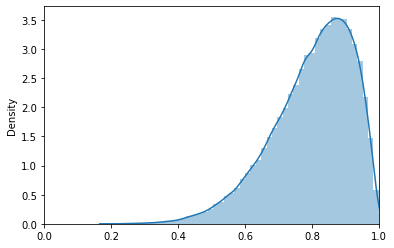

In [2]:
dist_8_2 = scipy.stats.beta(a=8, b=2)  # create the distribution

hist_8_2 = sns.distplot(dist_8_2.rvs(100000))  # draw 100k random values and plot
hist_8_2.set_xlim(0,1);

/Users/jdeppen/miniconda3/envs/prospect-guide/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


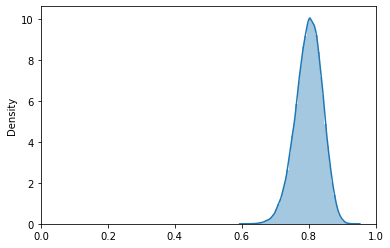

In [3]:
dist_80_20 = scipy.stats.beta(a=80, b=20)  # create the distribution

hist_80_20 = sns.distplot(dist_80_20.rvs(100000))  # draw 100k random values and plot
hist_80_20.set_xlim(0,1);

/Users/jdeppen/miniconda3/envs/prospect-guide/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


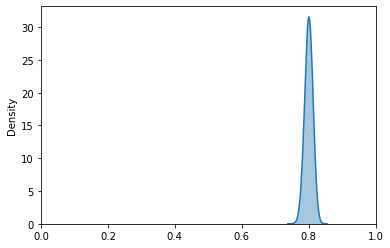

In [4]:
dist_800_200 = scipy.stats.beta(a=800, b=200)  # create the distribution

hist_800_200 = sns.distplot(dist_800_200.rvs(100000))  # draw 100k random values and plot
hist_800_200.set_xlim(0,1);

Notice how, as the total number of observations increases (10 -> 100 -> 1000), the distribution seems to approach a normal distribution. Thus, when modeling discovery parameters, it makes sense to use smaller values when there is less confidence in the actual value.

#### Truncated normal distributions

A truncated normal distribution may be appropriate for many of the parameters. For example, we might expect the time it takes to record a single `Feature` (i.e., `time_penalty`) to be normally distributed: sometimes it takes longer than the mean, sometimes shorter. However, if the mean value is relatively small and the standard deviation relatively large, the regular normal distribution might stretch below 0, as we can see in this example.

/Users/jdeppen/miniconda3/envs/prospect-guide/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


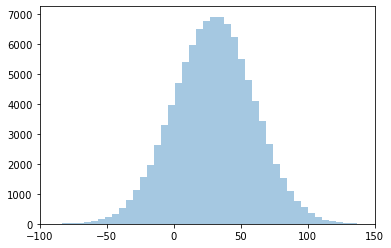

In [5]:
dist_norm = scipy.stats.norm(loc=30, scale=30)

hist_norm = sns.distplot(dist_norm.rvs(100000), kde=False)  # draw 100k random values and plot
hist_norm.set_xlim(-100,150);

Elapsed time, however, cannot be less than 0, so we need to truncate the distribution there.

Like for the Beta distribution, `prospect` provides a wrapper around the `scipy.stats` version of the distribution. However, unlike the Beta distribution, it is recommended that you use the `prospect.utils` version of `truncnorm` because it provides more intuitive parameters for the typical `prospect` use cases.

Let's recreate the same distribution as above only this time as a *truncated* normal distribution.

In [6]:
import prospect

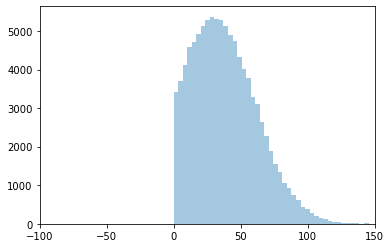

In [7]:
dist_trunc = prospect.utils.truncnorm(mean=30, sd=30, lower=0, upper=200)

hist_trunc = sns.distplot(dist_trunc.rvs(100000), kde=False)  # draw 100k random values and plot
hist_trunc.set_xlim(-100,150);

Even for cases where the value is *unlikely* to be near 0, it is still a good idea to bound the distribution at 0. For example, the minimum time per unit might have a mean of 600 seconds with a standard deviation of 60.

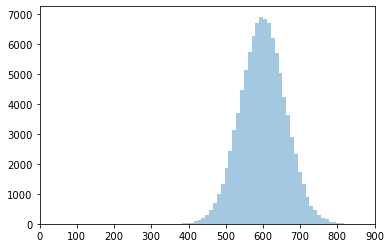

In [8]:
dist_norm2 = scipy.stats.norm(loc=600, scale=60)

hist_norm2 = sns.distplot(dist_norm2.rvs(100000), kde=False)
hist_norm2.set_xlim(0,900);

The truncated version will look very similar. 

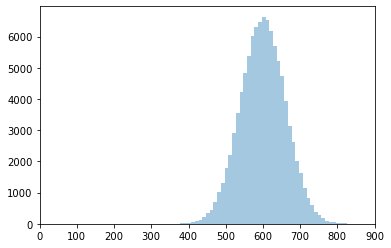

In [9]:
dist_trunc2 = prospect.utils.truncnorm(mean=600, sd=60, lower=0, upper=900)

hist_trunc2 = sns.distplot(dist_trunc2.rvs(100000), kde=False)
hist_trunc2.set_xlim(0,900);

```{tip}
It is safer to use the truncated distribution to avoid any chance that a value less than 0 is drawn during a survey run.
```

## Next...
We will have a brief introduction to some of the basic Python objects that make up the `prospect` package.